In [1]:
# some standard python imports #
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
%matplotlib inline

#lenstronomy imports
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.Util import kernel_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence

## Simulation Cosmology Choices

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.0394
z_source = 1.695
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

## Data Stuff 

Here, we are setting the properties of the data and the point spread function. This characterises things which are specific to the telescope and its location (background, exposure time, number of pixels, pixel size etc), as well as the point spread function (PSF).

The point spread function describes how the telescope responds to a point source. Light reaching the telescope as a single point will be spread out into an extended blob.

These data and PSF properties are separately

In [3]:
# properties of the data and PSF

background_rms = .05  # background noise per pixel
exp_time = 100.  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)

kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

## Lens Model kwargs

The lens is modelled as an elliptical power-law convergence profile with external shear

param_util is simply used to convert between coordinate systems. Here, the shear parameters (phi, which is the shear angle in radians, and gamma, which is the shear strength), are converted into the alternative shear parameters gamma1 and gamma2, which are those which must be given as the shear keywords in the lens model class

The elliptical power law convergence profile represents "a spherically averaged Einstein radius as a logarithmic 3D mass profile slope".

Because we are doing time delays, the redshifts and cosmology must also be specified. However, if the time delays weren't relevant, this would not be necessary

In [4]:
# the lens model

lens_model_list = ['SPEP', 'SHEAR']

gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angle (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_spemd = {'theta_E': 1., 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.05, 'e2': 0.05}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo)


## Light Profiles

Defining the light profiles for both the lens and the source. The lens is described by a spherical sersic profile, while the source is described by an elliptical sersic profile.

A spherical sersic profile has the form

ln I(R) = ln I_0 - kR^(1/n)

the amp is the surface brightness/amplitude value at the half light radius

R_sersic is the semi-major axis of the half light radius
n_sersic is the Sersic index

As before, we are specifying the profiles with which we want to model the light from both lens and source, and then their keyword argument

*quick aside: a useful way to define ellipticities

`phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)`


In [5]:
# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic = {'amp': 3000, 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0, 'e1': -0.15, 'e2': 0.04}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# 'SERSIC_ELLIPSE': elliptical Sersic profile
source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.1
kwargs_sersic_ellipse = {'amp': 8000., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

## Solving the Lens Equation

the LensEquationSolver class allows image positions to be determined from a given lens model and source position. 

Here, we specifically use the "**FindBrightImage**" function. This follows the "image_position_from_source", which finds the image positions in the lens plane that are mapped to a given source position. 

**image_position_from_source** takes in the source position, lens keywords and the type of solver as arguments. In this case, this is left to the default which is described as follows

*The solver first samples does a grid search in the lens plane, and the grid points that are closest to the supplied source position are fed to a specialized gradient-based root finder that finds the exact solutions. Works with all lens models.

What **FindBrightImage** does, however, is to carry out this calculation to determine the angular positions of the (potentially multiple) images. The magniications of these images are then calculated and used to rank the images by decreasing images. The selectBest function from util is then used to identify the specified number of images with the highest magnifications. 

*Note, FindBrightImage could also be used to select images with the highest Fermat potential

In this case, we want to identify the 4 images with the highest magnifications

In [6]:
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)


## Computing and Perturbing the Magnifications

To calculate the magnifications of the images, we use lens_model_class.magnification, and input the 4 image positions as arguments, as well as the lens keyword arguments. 

We then take the absolute values of these (**why must they be positive?**), and perturb them using np.random.normal. These perturbations could result from micro-lensing effects, for example. The first input is the centre of the normal distribution, the second is the standard deviation, and the third is the output shape (we want as many outputs as there are inputs here).


In [7]:
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification

# perturb observed magnification due to e.g. micro-lensing
mag_pert = np.random.normal(mag, 0.5, len(mag))


## Setting Up the PointSource Class

The magnitudes outputted from lens_model_class.magnification must be multiplied by the intrinsic quasar brightness in counts per second (which is taken to be 100) to give the point source amplitude.

We use the lensed positions as the inputs for point source, as well as the point_amp.

As we have the positions of our 4 lensed objects, we use 'Lensed_Position' as the point source type. Because of this, we set the fixed magnification list to false.

**I need to understand all the point source stuff better though. 

In [8]:
point_amp = mag_pert * 100  # multiply by intrinsic quasar brightness (in counts/s)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]  # quasar point source position in the source (shouldn't it be lens?) plane and intrinsic brightness

# note: the relative magnification of point sources is not used as constraints in the fitting in the default settings of lenstronomy.
# you can set this constraint with the keyword 'fixed_magnification_list' (see next block). The images are treated otherwise as separate linear amplitudes that are constraint independently of each other.

point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

## Creating the Image

We now have all the ingredients we need to simulate and plot the actual image. 

Firstly, we must define the numerics keyword arguments. These choices seem to be pretty standard.

The image model must be given all of the classes (data, psf, lens_model, source_model, lens_light_model, point_source), and the numerics kwargs.  Then the image is found by calling imageModel.image, and giving the lens, source, lens_light and point source kwarrgs,

After this has been done, add_poisson from image_util is used to add a Poissonian distributed noise. All the arguments that this needs is the simulated image and the exposure time as arguments. This gives noise values for each pixel, which is calculated as a randomly-sampled value from the normal value, multiplied by the square root of the image value over the exposure time.

A background is also added using add_background from image_util, which adds background noise. Essentially, each pixel gains a background value, drawn from the normal distribution with centre 0, and multiplied by the rms value of the background (inputted earlier when defining the data).

The final image is then created by adding the background and poisson noise of each pixel to the simulated image.

The image_data component of the data class kwargs is then updated to be this simulated image. Previously, it was simply np.zeros((numPix,numPix)).

The image is then plotted.

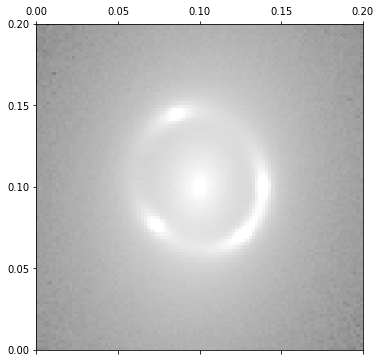

In [9]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 0.2, 0, 0.2])
#ax.autoscale(False)
plt.show()

## Time Delays

time delays are defined in lenstronomy as the difference in light travel path relative to a straight line. Negative values correspond to earlier arrival times. The units are in days.

The class which must be used here is TDCosmography. This takes the redshifts of the lens and the source, all the kwargs of the model, and the fiducial cosmology as inputs

To extract the absolute time delays, the time_delays function is called from this class. This predicts the time delays of the image positions given the fiducial cosmology relative to a straight line without lensing. Negative values correspond to images arriving earlier, and positive signs correspond to images arriving later.This additionally needs the lens model kwargs, the point source kwargs, and has the option of an external convergence (kappa_ext)

To find the relative time delays, the first image is generally used as a reference.

In [10]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

# time delays, the unit [days] is matched when the lensing angles are in arcsec
t_days = td_cosmo.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ", t_days)

# relative delays (observable). The convention is relative to the first image
dt_days =  t_days[1:] - t_days[0]
# and errors can be assigned to the measured relative delays (full covariance matrix not yet implemented)
dt_sigma = [3, 5, 10]  # Gaussian errors
# and here a realisation of the measurement with the quoted error bars
dt_measured = np.random.normal(dt_days, dt_sigma)
print("the measured relative delays are: ", dt_measured)

the time delays for the images at position  [-0.35838653  0.66329879  0.97539949 -0.66446448] [ 1.10554326 -0.72985136  0.01070259 -0.58570979] are:  [-3.07806822 -2.15431871 -2.06613726 -1.71161047]
the measured relative delays are:  [2.45097458 2.9529207  5.75204374]


##  Setting Up the Modelling

### Param Stuff

The type of lens model, source light model, lens light model and point source model are kept the same as before. To see the things which need to be set here, create_class_instances in class_creator in util can be looked at. Those which are specified here are

- lens_model_list: list of strings indicating the type of lens models
- source_light_model_list: list of strings indicating the types of source light models
- lens_light_model_List: list of strings indicating the types of lens light models
- point_source_model_list: list of strings indicating the point source types
- additional_images_list: what I can find is this. Not sure why it's set to `False`, as opposed to `None` 

`if additional_images_list is not None:
    additional_images_list_i = [additional_images_list[k] for k in index_point_source_model_list[band_index]]`
    
- fixed_magnification_list: this has the exact same thing as abbove for additional_images_list. Setting it to False means that the magnification ratio of point sources isn't fixed to the one given by the lens model, and so the model might arrive at a different ratio. It must be a list of booleans (True vs False) which is the same length as the point_source_type_list

num_source_model is simply the number of light profiles used to model the source, which in this case is 1.

kwargs_constraints are the keyword arguments of the Param() class to handle parameter constraints during the sampling (except upper and lower limits and sampling input mean and width)

- 'joint_source_with_point_source': list [[i_point_source, k_source], [...], ...],
    joint position parameter between lens model and source light model. Not sure exactly how this works
- 'num_point_source_list': the list of number of point sources per point source model class (in this case there's just one point source model class, and there are 4 point sources in this)
- 'solver_type': which solver type to use. The options are 'profile', 'profile_shear', 'ellipse', 'centre' or none'
- 'Ddt_sampling': bool, if True, samples the time-delay distance D_dt (in units of Mpc)

In [11]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list,
                'point_source_model_list': point_source_list,
                'additional_images_list': [False],
                'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
                             }

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_source_with_point_source': [[0, 0]],
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
                              }

### Likelihood stuff

Firstly, we specify priors for the two shear components, e1 and e2. We assume that both are zero, and give the standard deviation with which we expect them to be distributed (**is this correct?**)

We then set various keyword arguments for the likelihood class.

- check_bounds: bool, option to punish the hard bounds in parameter space (not sure what it means to punish hard bounds in parameter space)
- force_no_add_image: bool, if True: computes ALL image positions of the point source. If there are more images predicted than modelled, a punishment occurs (I think, since this is false, it would be possible for the initial guess to predict more images than the model actually finds, but not really sure)
- source_marg: marginalization addition on the imaging likelihood based on the covariance of the inferred linear coefficients (???)
- image_position_uncertainty: 1-sigma Gaussian uncertainty on the point source position (only used if point_source_likelihood=True). Can't yet find anything about point_source_likelihood, so I'm not sure exactly how that works
- check_matched_source_position: option to check whether point source position solver finds a solution to match all the image positions in the same source plane coordinate
- source_position_tolerance: float, punishment of check_solver occurs when image positions ar epredicted further away than this number
- source_position_sigma: no info given, but the values used for this (and everything else) seems quite standard
- param time_delay_likelihood: bool, if True computes the time-delay likelihood of the FIRST point source

The data, psf and numerics kwargs are put together as image_band, which then is entered into the multi_band_list. Because there is only one band, this list just has one list (image_band) in it.

data_joint is how the data from multiple bands would be joined. the multi_band_type could be either multi-linear or joint-linear. However, none of this is particularly relevant, because there is only one band?

In [12]:
# we have the option to set priors in the model parameters.
prior_lens = [[0, 'e1', 0, 0.2], [0, 'e2', 0, 0.2]]#  [index_model, param_name, mean, 1-sigma priors]
# have a look in the LikelihoodModule for a complete description of implemented priors

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': False,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': True,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'prior_lens': prior_lens,
                     'time_delay_likelihood': True,
                     }

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear',
                    'time_delays_measured': dt_measured,
                    'time_delays_uncertainties': dt_sigma,}

### Sampler stuff

Sampling the likelihood. 

We need initial guesses of the starting parameters, which are deliberately set to differ from the data. 

The parameters which are being searched for in the lens model are the Einstein radius, ellipticities e1 and e2, power law slope of mass profile gamma, and the centre of the profile. The two shear components gamma1 and gamma2 are also guessed.

The parameters which are needed for the source light profile (elliptical sersic), are the R_sersic, n_sersic, the ellipticities and the centre. The same is true for the lens light profile.

Finally, the point source parameters are simply the x and y positions of the point images.

Next, we specify the sigma values for each of the parameters mentioned above, as well as hard upper and lower bounds for the values being searched for.

The only parameters we keep fixed are the coordinates of the external shear, which are chosen to stay at 0 (**is this correct? So the external shear is centred on the origin? Makes sense**)

These parameters are all then combined into kwargs_params, and kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood and kwargs_params are fed into the fitting sequence. 

In [27]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'gamma1': 0, 'gamma2': 0}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]
kwargs_cosmo_init = {'D_dt': 5000}

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.1, 'gamma2': 0.1}]
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]
kwargs_cosmo_sigma = {'D_dt': 2000}

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'gamma1': -0.5, 'gamma2': -0.5}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]
kwargs_lower_cosmo = {'D_dt': 0}

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'gamma1': 0.5, 'gamma2': 0.5}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]
kwargs_upper_cosmo = {'D_dt': 10000}

# keeping parameters fixed
kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
kwargs_source_fixed = [{}]
kwargs_lens_light_fixed = [{}]
kwargs_ps_fixed = [{}]
kwargs_cosmo_fixed = [{}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, kwargs_cosmo_fixed, kwargs_lower_cosmo, kwargs_upper_cosmo]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': cosmo_params}

## The Fitting 

We put all of the keyword argument lists from previously into the fitting sequence. The fitting sequence class with the function fit_sequence called takes a list of keyword arguments as an input, a separate list for each of the fitting routines used, and returns the fitting results. Here, both the PSO (particle swarm optimisation) and MCMC routines are used.

I think when best_fit is called, this gives the most accurate fitting result. In this case, it seems to match up with the MCMC run, but I presume it will choose whichever of the two has the smallest deviation from the data

In [28]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 200, 'n_iterations': 200}],
        ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}]
]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-20.043519257930594 reduced X^2 of best position
-99967.05229892884 logL
9975 effective number of data points
[{'theta_E': 1.0415489990840245, 'gamma': 2.254540522871407, 'e1': 0.06609519204021336, 'e2': 0.07128652334106543, 'center_x': 0.004716923787494839, 'center_y': -0.021484148455098825}, {'gamma1': 0.0067080918108960545, 'gamma2': -0.0066830353501449585, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 1.9319783410071243, 'n_sersic': 4.999994784500493, 'e1': -0.17393429191419083, 'e2': 0.05994624053055347, 'center_x': 0.004798444186485021, 'center_y': 0.13339315242032873}] source result
[{'amp': 1, 'R_sersic': 0.38003031192985165, 'n_sersic': 0.8064860985883353, 'e1': -0.1111899331471487, 'e2': 0.023436081622038918, 'center_x': 0.0005789945797647524, 'center_y': 0.005621665644618831}] lens light result
[{'ra_image': array([-0.34882215,  0.663010

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [09:11<00:00,  2.76s/it]

Computing the MCMC...
Number of walkers =  220
Burn-in iterations:  100
Sampling iterations (in current run): 200
553.2746698856354 time taken for MCMC sampling


## Plotting and Comparing Results

### Fitting Plots

Here, we can plot all of our results

Firstly, we define the ModelPlot class, which takes multi_band_list (recall `image_band = [kwargs_data, kwargs_psf, kwargs_numerics], multi_band_list = [image_band]`), the model kwargs, the result kwargs (which consists of the result of the best fit), and a specification of the arrow size and the color of the plots (`gist_heat` in this case). When this is defined, if n_data is greater than 0, the reduced X^2 of all evaluated imaging data combined is printed. This is calculated as 

reduced X^2 = logL * 2/ n_data

n_data is the number of independent data points in the combined fitting

L is the likelihood - the closer it is to 1, the more likely this combination of parameters accurately describes the data. Thus we would expect -logL to decrease with successive iterations, if these iterations are converging on the correct solution, and this is indeed what we observe.

Generally, you want a reduced chi-squared value as close to 1 as possible.

We then print the list of parameters which are fitted.

The `chain_plot.plot_chain_list(chain_list, i)` plots the 4 white-background graphs. Try to understand some of this better. 

This is all for the particle swarm optimisation - iteratively varying the parameters towards their optimum values

The first graph plots -logL as a function of the number of iterations. We see that its value decreases with successive iterations, meaning that the parameters are more and more likely to accurately describe the data.

The second plots the particle position - presumably, this is the distance of the parameter value away from its final value?

The third is the particle velocity - the amount by which the parameter changes per iteration?

No idea about the fourth

My confusion - I would imagine the particle position tells you how poor your initial guesses were, but when I make the worst one better, the fit gets worse 


-19.919036142987192 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  19.919036142987196
(22, ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt'])


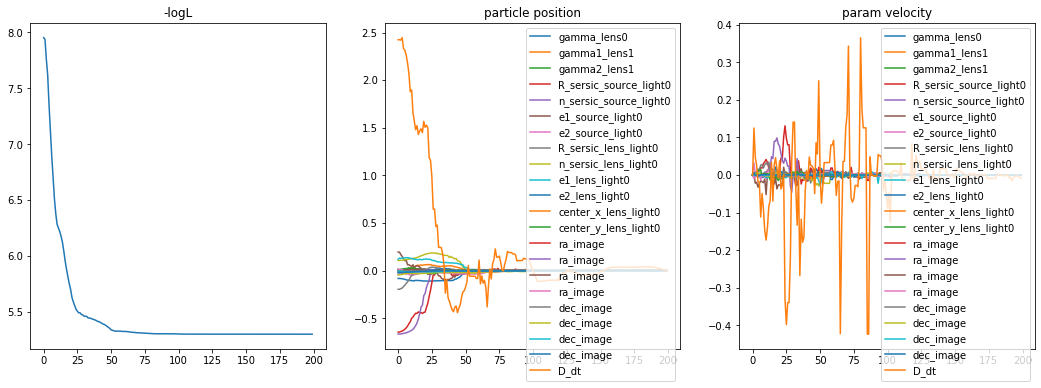

<Figure size 432x288 with 0 Axes>

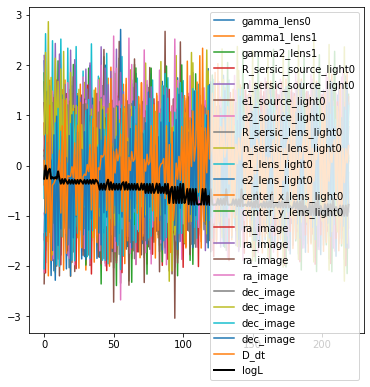

In [30]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

### Image Plots

We now plot images to represent the data and the fit. Firstly, we plot the data, and next to it the reconstructed from the model. 

On the top right are the normalised residuals. We want this to be as random as possible - an overly strong presence of blue or red, or any structure apparent in the residuals, would indicate problems with the fit.

On the next line, on the left, is a reconstruction of the source from the modelling. The quasar position is indicated with a star.

The next plot is the convergence - i.e., the projected surface mass density of the lens. Note: this is a plot of the mass distribution, not the light, as seen in the data frame.

Next is the magnification, which shows the lensing magnification in the field of view of the data frame

The next line of plots separate out the light from the lens and from the source (as modelled), and then combine them into the reconstructed image.

I don't understand the difference between convolved and unconvolved

c:\users\daniel johnson\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if __name__ == '__main__':


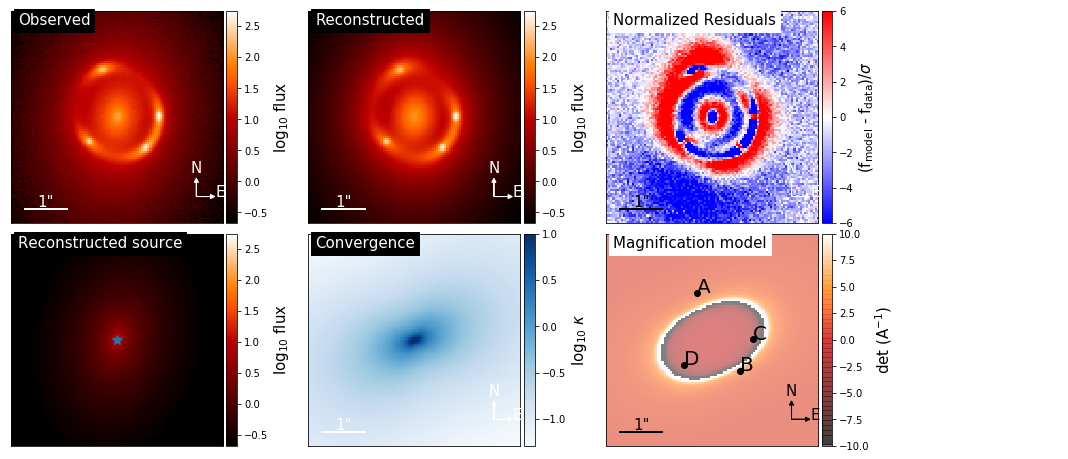

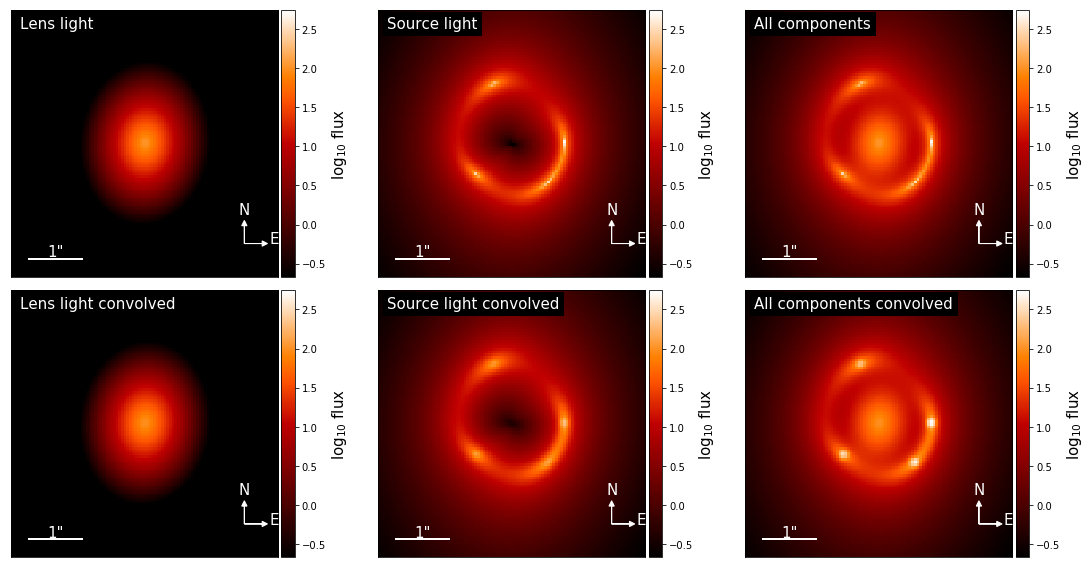

{'kwargs_lens': [{'theta_E': 1.0402263514059304, 'gamma': 2.2747354417174583, 'e1': 0.06188901114461801, 'e2': 0.06457352884807828, 'center_x': 0.004857238468957925, 'center_y': -0.016966611702285462}, {'gamma1': 0.0017337439891151136, 'gamma2': -0.015360644609759253, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 214.49490563681775, 'R_sersic': 1.9312819864725832, 'n_sersic': 4.994290605195085, 'e1': -0.17054426771886752, 'e2': 0.06970746199299356, 'center_x': 0.005114350333535675, 'center_y': 0.13331484497423832}], 'kwargs_lens_light': [{'amp': 12164.463703702997, 'R_sersic': 0.3789477741030752, 'n_sersic': 0.8102869892188447, 'e1': -0.11334535912428921, 'e2': 0.021356446049316854, 'center_x': 0.0023259721290966036, 'center_y': 0.0034845252408740707}], 'kwargs_ps': [{'ra_image': array([-0.34858309,  0.66283318,  0.97525135, -0.65994791]), 'dec_image': array([ 1.101671  , -0.72816459,  0.00671363, -0.58633096]), 'point_amp': array([ 667.89119636, 1619.83641177, 1964.27564662, 1086

In [31]:
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1,cmap='Blues')
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

## Plotting MCMC Posteriors

### 'Raw' Posteriors

As I understand it, these plots show how likely a parameter is to take on a certain value, given a different value of another parameter. Then the plots at the end are the 1D posteriors - simply how likely a parameter is to have a certain value

number of non-linear parameters in the MCMC process:  22
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  22000


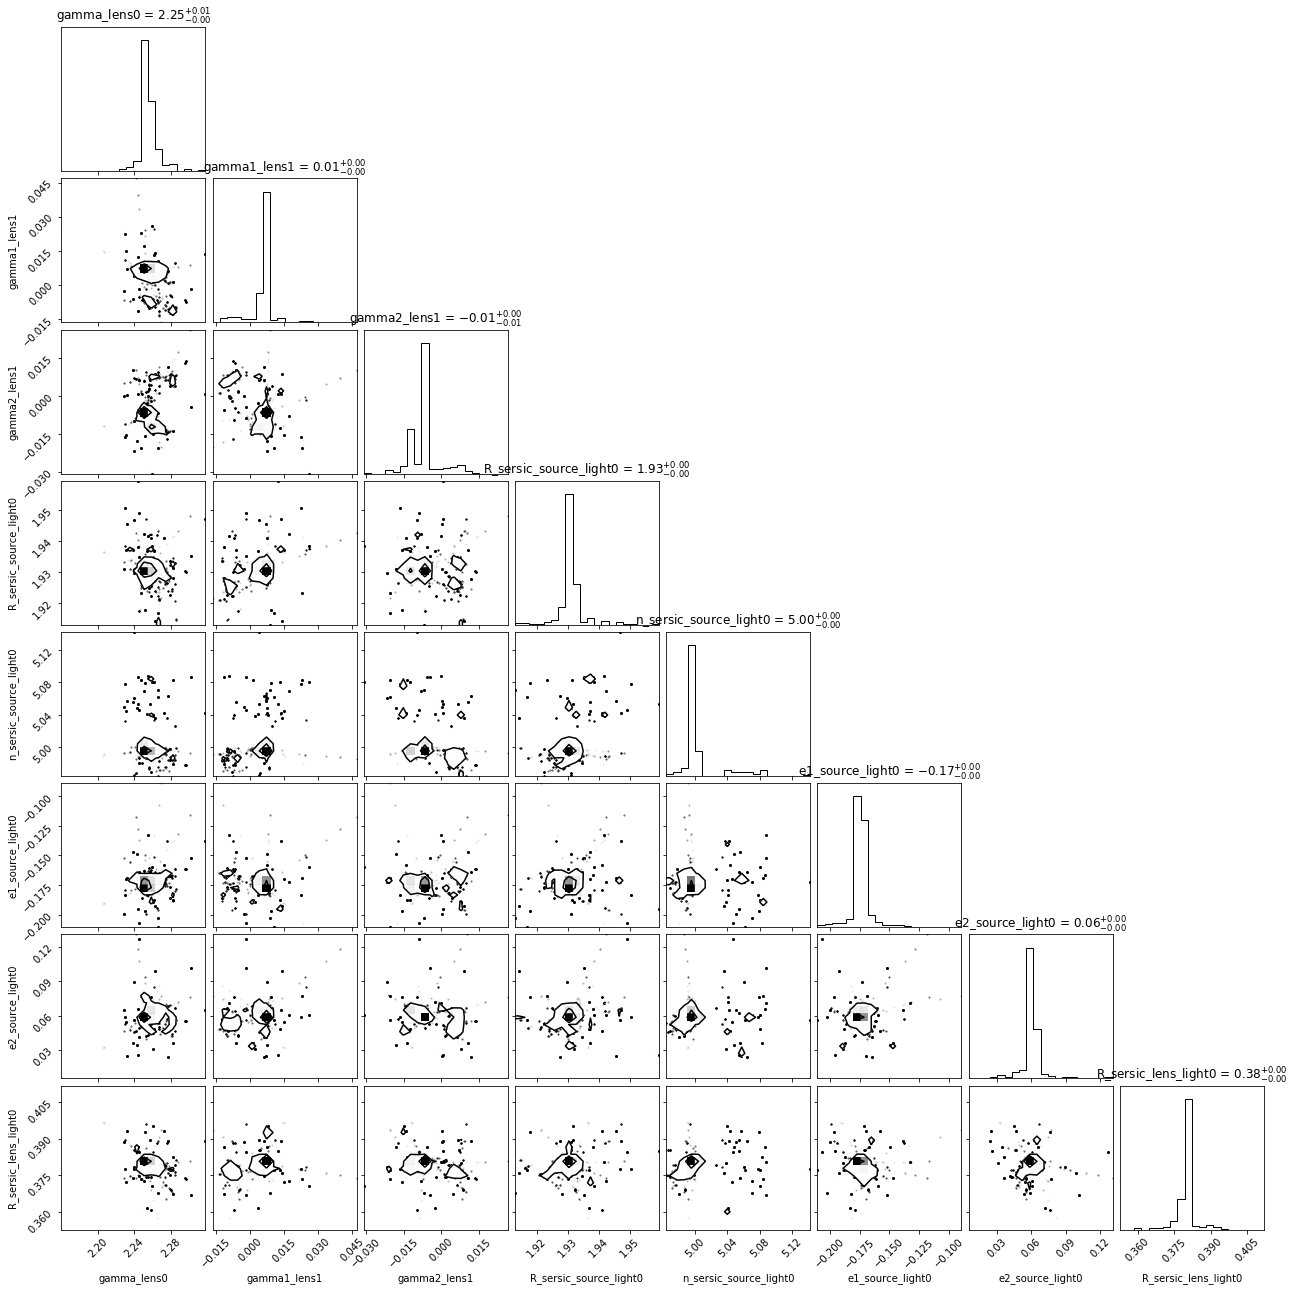

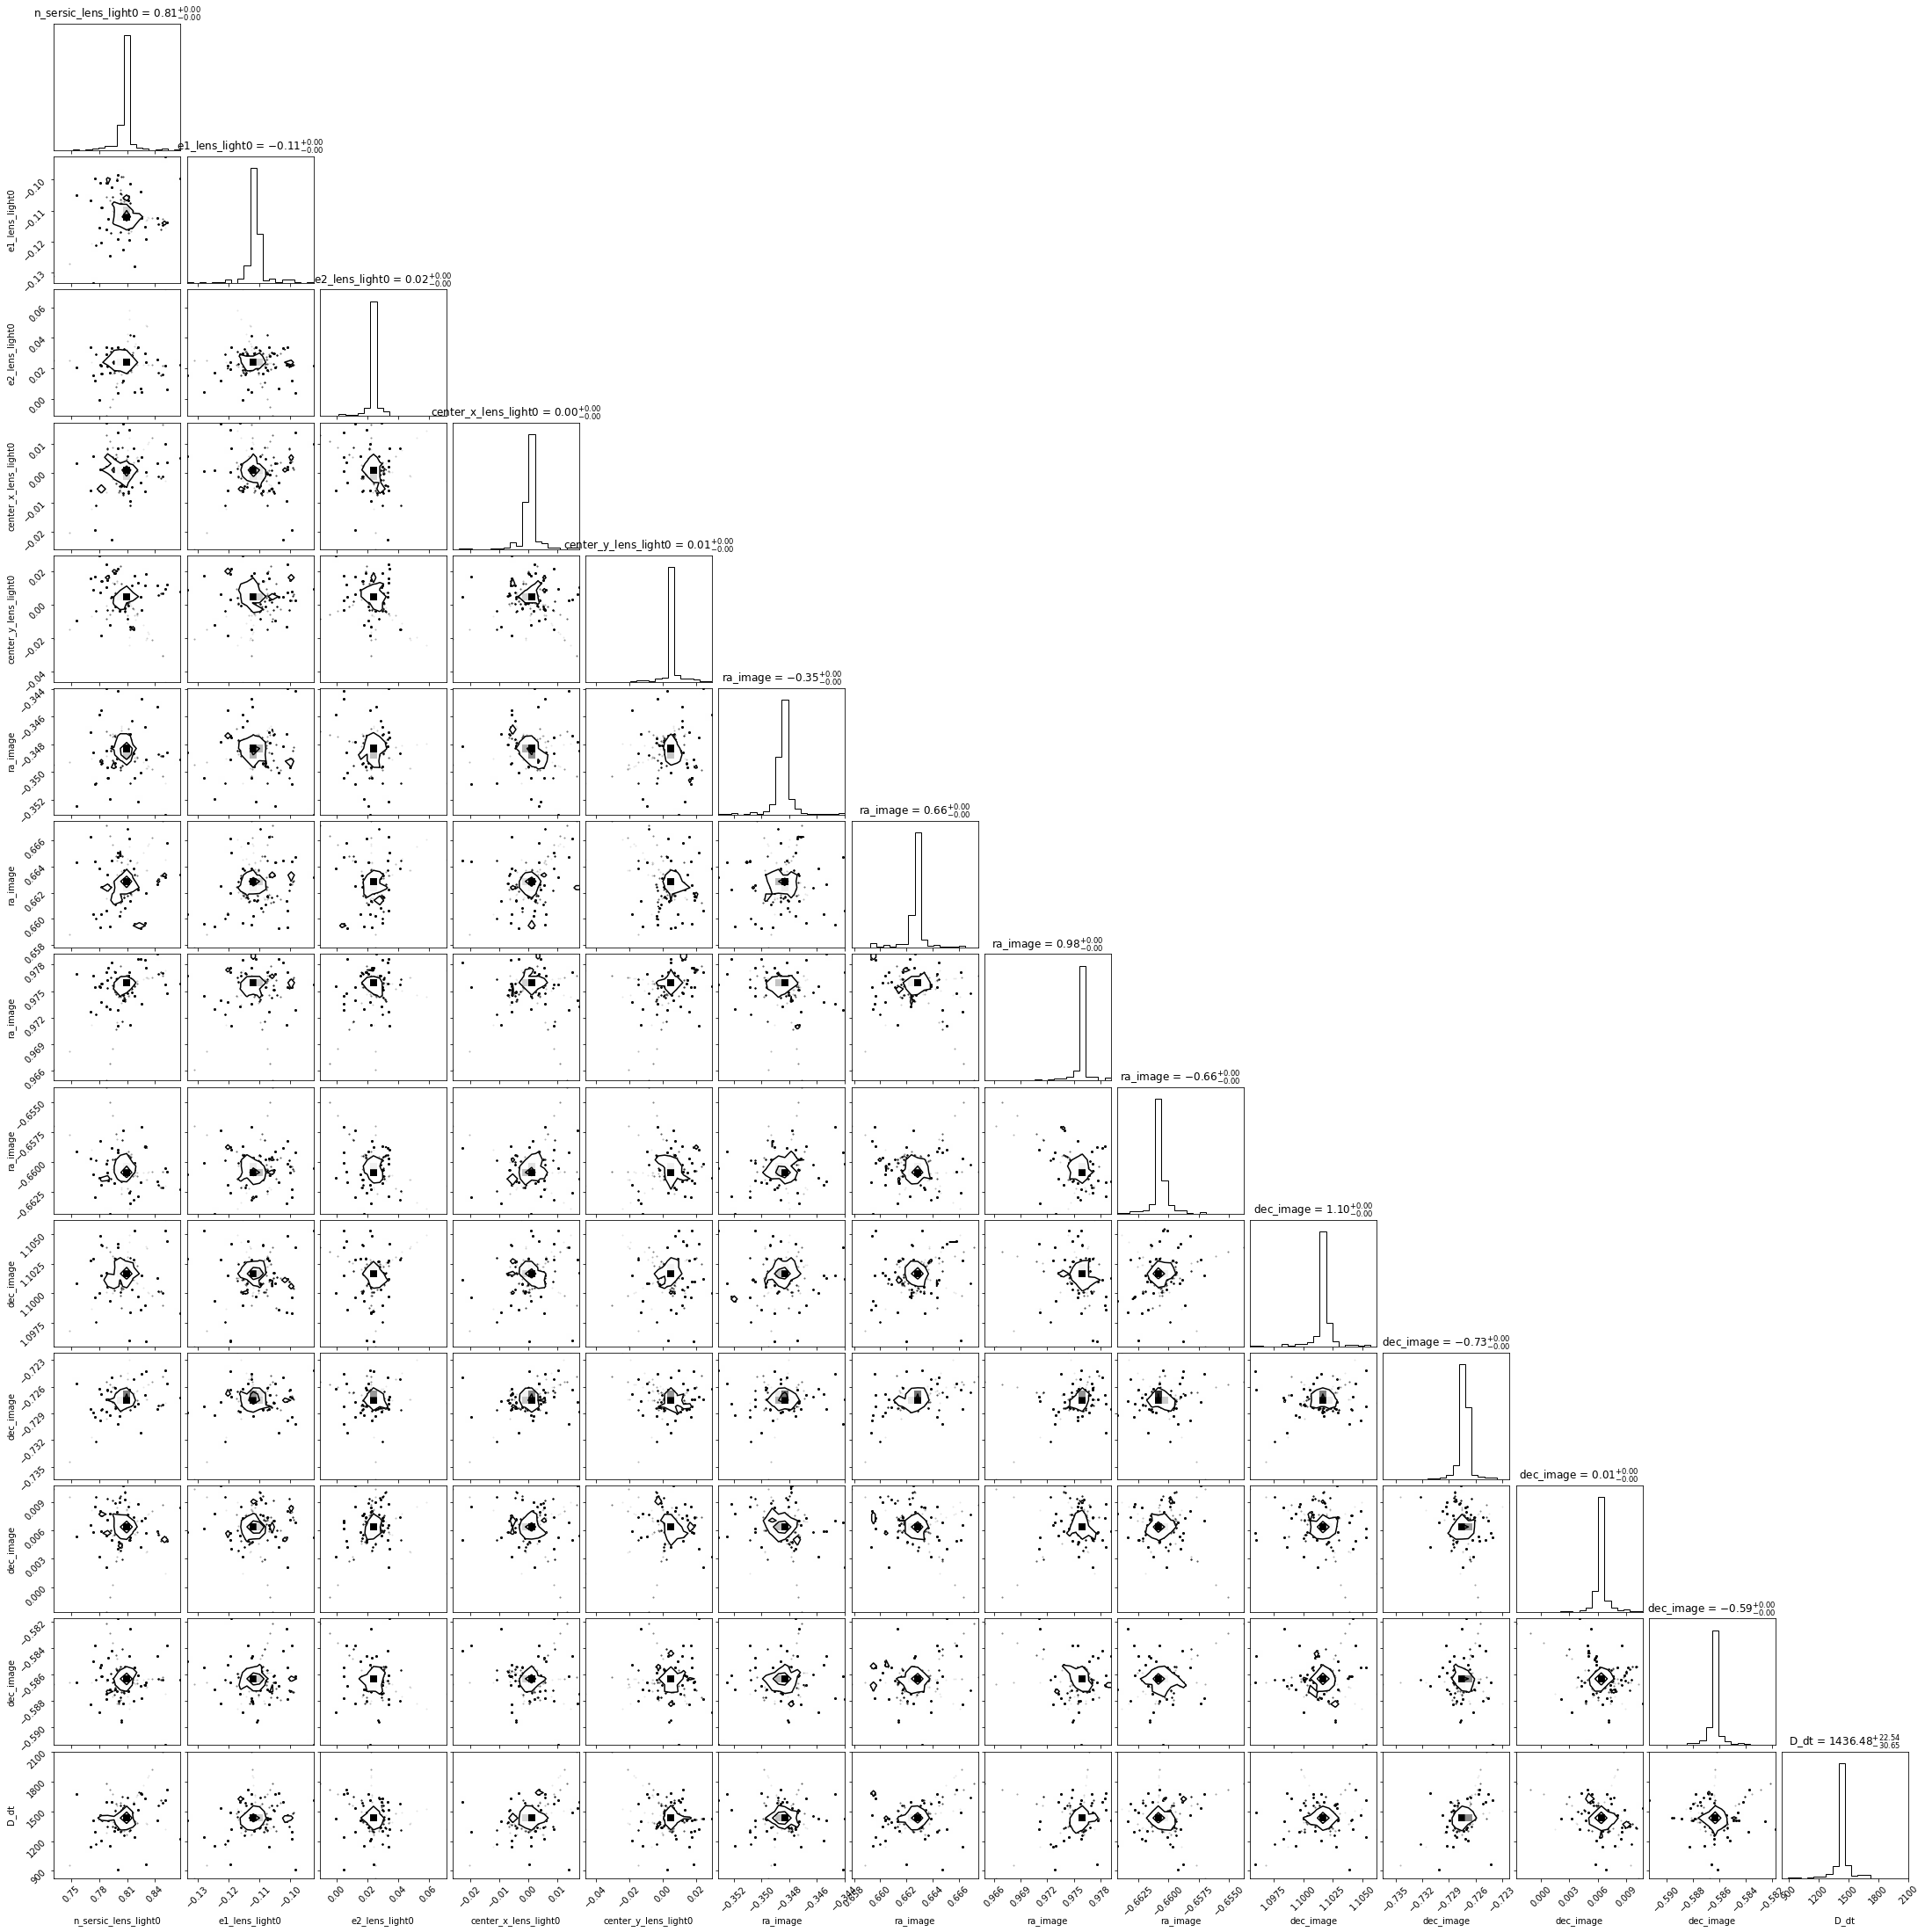

In [33]:
# here we plot the 'raw' MCMC posteriors

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)

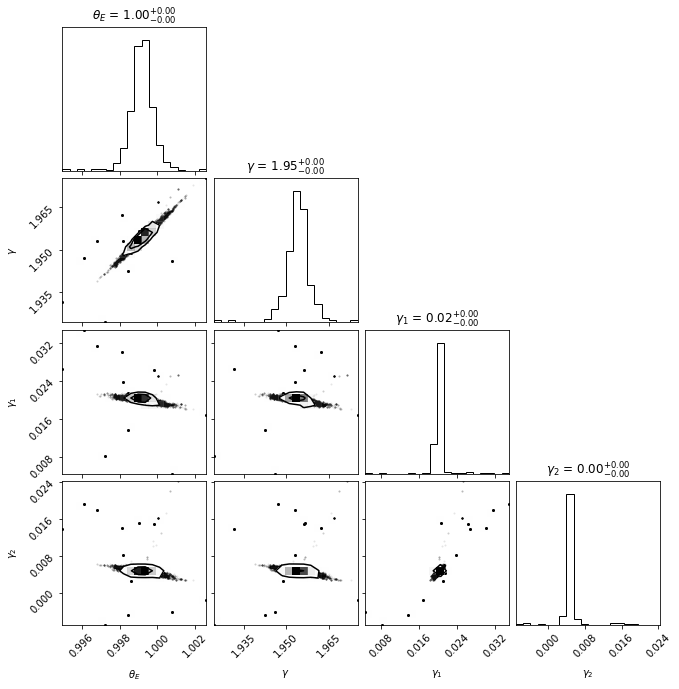

In [18]:
# here we plot a subset of the 'processed' MCMC posteriors

# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, kwargs_lens_fixed, kwargs_source_fixed, kwargs_lens_light_fixed, kwargs_ps_fixed, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\gamma_1$", r"$\gamma_2$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    theta_E = kwargs_result['kwargs_lens'][0]['theta_E']
    gamma = kwargs_result['kwargs_lens'][0]['gamma']
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    mcmc_new_list.append([theta_E, gamma, gamma1, gamma2])


plot = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)

In [34]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
print(lensCosmo.ddt)

173.39369148433522
